# Avoir plusieurs axes des ordonnées

Le but de ce cahier est d'afficher plusieurs séries concommittantes mais sur des domaines différents. Elles partagent l'axe des abscisses mais on chacune un axe des ordonnées différent.

Une discussion très intéressante a été initié sur la chaîne [stackoverflow](https://stackoverflow.com/questions/11640243/plot-multiple-y-axes).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from random import randrange

On commence par générer trois listes de 100 points prenant des nombres aléatoires avec [randrange](https://docs.python.org/3/library/random.html#random.randrange) pris sur trois domaines différents. On utilise pour cela la technique de création d'un dataframe à partir d'un dictionnaire. Les clés de ce dictionnaire seront les titres des colonnes, ses valeurs seront les listes de valeurs pour chaque enregistrement. La contrainte est donc que chacune de ces listes aient la même longueur.

In [3]:
df = DataFrame(dict(
    A=[randrange(-1000, 1000) for _ in range(10)],
    B=[randrange(-100, 100) for _ in range(10)],
    C=[randrange(-10, 10) for _ in range(10)],
))
# df = DataFrame(np.random.randn(5, 3), columns=['A', 'B', 'C'])
df.head(3)

,A,B,C
0,150,58,-10
1,590,-67,7
2,591,15,6


Pour créer un nouveau graphe (un /axes/ selon le vocabulaire de matplotlib), on utilise la méthode [twinx](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html) qui crée donc un nouveau graphe qui partage le même axe des `x` que le graphe d'origine. La définition de la positon exact de l'axe des ordonnées de ce nouveau graphe `ax3` se fait avec la méthode `spines`. On trouvera plus de détail sur les options de placement [ici](https://matplotlib.org/stable/gallery/spines/spine_placement_demo.html).

On ne définit pas de `ax2` car la deuixème série utilise `ax` mais avec l'axe secondaire des ordonnées.

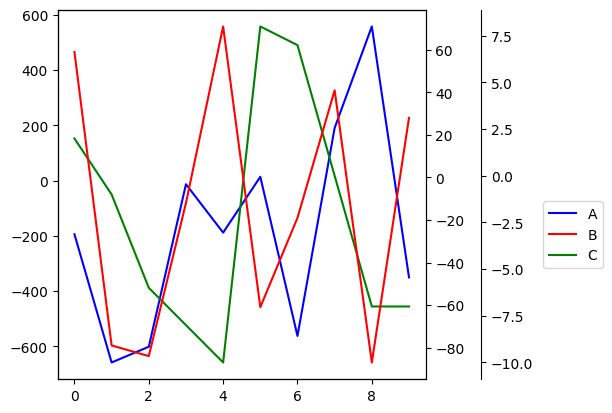

In [3]:
fig, ax = plt.subplots()
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.15))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

df.A.plot(ax=ax, style='b-')
# same ax as above since it's automatically added on the right
df.B.plot(ax=ax, style='r-', secondary_y=True)
df.C.plot(ax=ax3, style='g-')

# add legend --> take advantage of pandas providing us access
# to the line associated with the right part of the axis
ax3.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0], ax3.get_lines()[0]],\
           ['A','B','C'], bbox_to_anchor=(1.5, 0.5))

Une des utilisateurs propose alors la définiton d'une fonction pour rendre ces techniques plus simples à réutiliser.

In [4]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas.plotting._matplotlib.style import get_standard_colors

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = get_standard_colors(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])
        
        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

<Axes: ylabel='s1'>

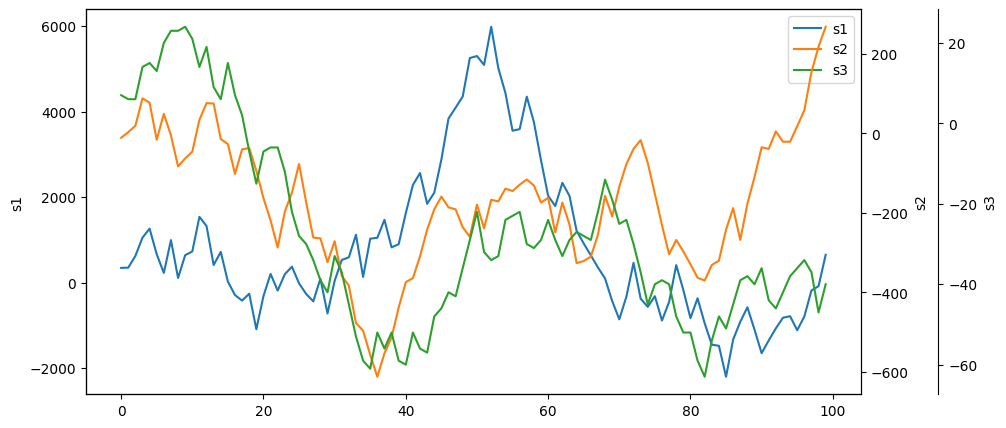

In [5]:
import pandas as pd
from random import randrange

data = pd.DataFrame(dict(
    s1=[randrange(-1000, 1000) for _ in range(100)],
    s2=[randrange(-100, 100) for _ in range(100)],
    s3=[randrange(-10, 10) for _ in range(100)],
))

plot_multi(data.cumsum(), figsize=(10, 5))

Cette fonction a été améliorer pour tenir compte de plus de cas et aussi inclure une meilleure documentation.

In [6]:
from typing import List, Union

import matplotlib.axes
import pandas as pd

def plot_multi(
    data: pd.DataFrame,
    x: Union[str, None] = None,
    y: Union[List[str], None] = None,
    spacing: float = 0.1,
    **kwargs
) -> matplotlib.axes.Axes:
    """Plot multiple Y axes on the same chart with same x axis.

    Args:
        data: dataframe which contains x and y columns
        x: column to use as x axis. If None, use index.
        y: list of columns to use as Y axes. If None, all columns are used
            except x column.
        spacing: spacing between the plots
        **kwargs: keyword arguments to pass to data.plot()

    Returns:
        a matplotlib.axes.Axes object returned from data.plot()

    Example:
    >>> plot_multi(df, figsize=(22, 10))
    >>> plot_multi(df, x='time', figsize=(22, 10))
    >>> plot_multi(df, y='price qty value'.split(), figsize=(22, 10))
    >>> plot_multi(df, x='time', y='price qty value'.split(), figsize=(22, 10))
    >>> plot_multi(df[['time price qty'.split()]], x='time', figsize=(22, 10))

    See Also:
        This code is mentioned in https://stackoverflow.com/q/11640243/2593810
    """
    from pandas.plotting._matplotlib.style import get_standard_colors

    # Get default color style from pandas - can be changed to any other color list
    if y is None:
        y = data.columns

    # remove x_col from y_cols
    if x:
        y = [col for col in y if col != x]

    if len(y) == 0:
        return
    colors = get_standard_colors(num_colors=len(y))

    if "legend" not in kwargs:
        kwargs["legend"] = False  # prevent multiple legends

    # First axis
    ax = data.plot(x=x, y=y[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=y[0])
    lines, labels = ax.get_legend_handles_labels()

    for i in range(1, len(y)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines["right"].set_position(("axes", 1 + spacing * (i - 1)))
        data.plot(
            ax=ax_new, x=x, y=y[i], color=colors[i % len(colors)], **kwargs
        )
        ax_new.set_ylabel(ylabel=y[i])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

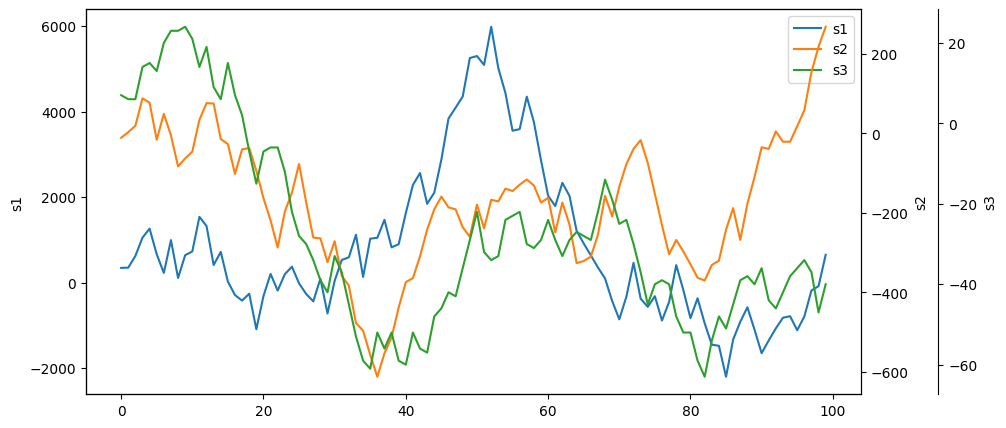

In [7]:
plot_multi(data.cumsum(), figsize=(10, 5))
plt.show()

# Tracer des jeux de courbes à partir d'un dataframe

L'extension a sa propre [implémentation de matplotlib](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html?highlight=dataframe%20plot#pandas.DataFrame.plot) qu'il est intéressant d'utiliser dès qu'on utilise des dataframes (il existe la même chose pour les [series](https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.html#pandas.Series.plot) de pandas).

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from random import randrange

On reprendre le dataframe de démonstration

In [5]:
data = DataFrame(dict(
    s1=[500 + 10* np.sqrt(n) + randrange(-10, +5) for n in range(100)],
    s2=[100 + randrange(-5, 5) for n in range(100)],
    s3=[80 + randrange(-5, 5) for _ in range(100)],
))
data

,s1,s2,s3
0,502.000000,100,83
1,508.000000,95,84
2,518.142136,102,77
3,512.320508,96,76
4,522.000000,103,83
...,...,...,...
95,597.467943,101,81
96,596.979590,97,81
97,598.488578,99,80
98,590.994949,102,79


Renommer les titres de colonnes.

In [6]:
data.rename(columns={
    's1': 'temperature [°C] , 000CT401',
    's2': 'pression [bar] , 000CP203',
    's3': 'débit [T/h] , 000CF101'
    }, inplace=True)
data.head()

,"temperature [°C] , 000CT401","pression [bar] , 000CP203","débit [T/h] , 000CF101"
0,502.000000,100,83
1,508.000000,95,84
2,518.142136,102,77
3,512.320508,96,76
4,522.000000,103,83


Séparer les noms de colonnes en titres, unités et codes. On utilise la commande [split](https://docs.python.org/3/library/stdtypes.html) et les [expressions régulières](https://docs.python.org/3/library/re.html).

In [7]:
import re
labels = []
units = []
codes = []
m = re.compile("(^[^[]*) \[([^]]*)\]$")

for str in data.columns:
    LB,CD = str.split(' , ')
    LB, UN = m.match(LB).groups()
    # print(LB, UN, CD, sep='|---|') # for debug
    labels.append(LB)
    codes.append(CD)
    units.append(UN)

# Dé-commentez votre choix
# presentation = 'simple'
presentation = 'tabulate'

match presentation:
    case 'simple':
        for LB, UN, CD in zip(labels, units, codes):
            print(LB, UN, CD, sep='|---|')

    case 'tabulate':
        # pour présenter les résultats un peu mieux
        from tabulate import tabulate
        M = np.array([labels,units,codes]).T  # on doit transposer
        print(tabulate(M, headers=['mesure', 'unit', 'code'], tablefmt='simple_grid'))


┌─────────────┬────────┬──────────┐
│ mesure      │ unit   │ code     │
├─────────────┼────────┼──────────┤
│ temperature │ °C     │ 000CT401 │
├─────────────┼────────┼──────────┤
│ pression    │ bar    │ 000CP203 │
├─────────────┼────────┼──────────┤
│ débit       │ T/h    │ 000CF101 │
└─────────────┴────────┴──────────┘


Création d'une liste de dates

In [8]:
from datetime import timedelta, date, datetime

d0 = datetime.fromisoformat('2023-04-20 08:00')
dates = [d0]
for d in range(99):
    d0 += timedelta(minutes=2)
    dates.append(d0)

len(dates)

100

Rajout d'une colonne contenant ces dates & temps et on le déclare comme l'index de la table.

In [9]:
data['datetime'] = dates
data.set_index('datetime', inplace=True)
data.head()

,"temperature [°C] , 000CT401","pression [bar] , 000CP203","débit [T/h] , 000CF101"
datetime,,,
2023-04-20 08:00:00,502.000000,100,83
2023-04-20 08:02:00,508.000000,95,84
2023-04-20 08:04:00,518.142136,102,77
2023-04-20 08:06:00,512.320508,96,76
2023-04-20 08:08:00,522.000000,103,83


Un problème rencontré couramment est d'imprimer un faisceau de courbe correspondant aux données du dataframe. La caractéristique de ces données sera toujours de partager le même axe des abscisses, qui correspondra aux index du dataframe. Les ordonnées seront les valeurs prises dans chaque colonne, une par une, chaque colonne représentant une mesure particulière, dont le titre pourra être utilisé pour construire la légende du faisceau de courbes.

Deux cas se présenteront ensuite :
- soit les valeurs des colonnes utiliseront le même axe des ordonnées (les valeurs sont exprimées dans la même unité de mesure);
- soit ces valeurs auront besoin d'axes différents.

Dans le premier cas, on lancera la commande `plot` sur le dataframe (ou le sous-ensemble du dataframe) et il faudra caractériser les couleurs par des cartographies de couleurs (avec l'option `colormap=`), les styles par une liste de style et ainsi de suite.

Dans le deuxième cas, on utilisera des graphes jumeaux avec avec la commande [twinx()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html) pour pouvoir contrôler plus finement ces éléments.


Dans l'exemple qui est donné, nous avons besoin de trois axes des ordonnées différents, donc on utilise la deuxième méthode.

In [7]:
for str in data.columns:
    print(str)

temperature [°C] , 000CT401
pression [bar] , 000CP203
débit [T/h] , 000CF101


La commande [plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) reprend les principales de la même commande dans [matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Elle renvoie un objet `ax` qui a est créé à ce moment. Ceci permet ensuite de paramétrer les propriétés de cet objet.

Nous aurons typiquement trois objets à personnaliser:
- l'axe des ordonnées (`spine`)
- les graduations (`yticks`) et leur étiquettes
- les titres des ordonnées (`ylabel`)

On peut aussi vouloir [formatter](https://matplotlib.org/stable/api/ticker_api.html#tick-formatting) les étiquettes des graduations. 

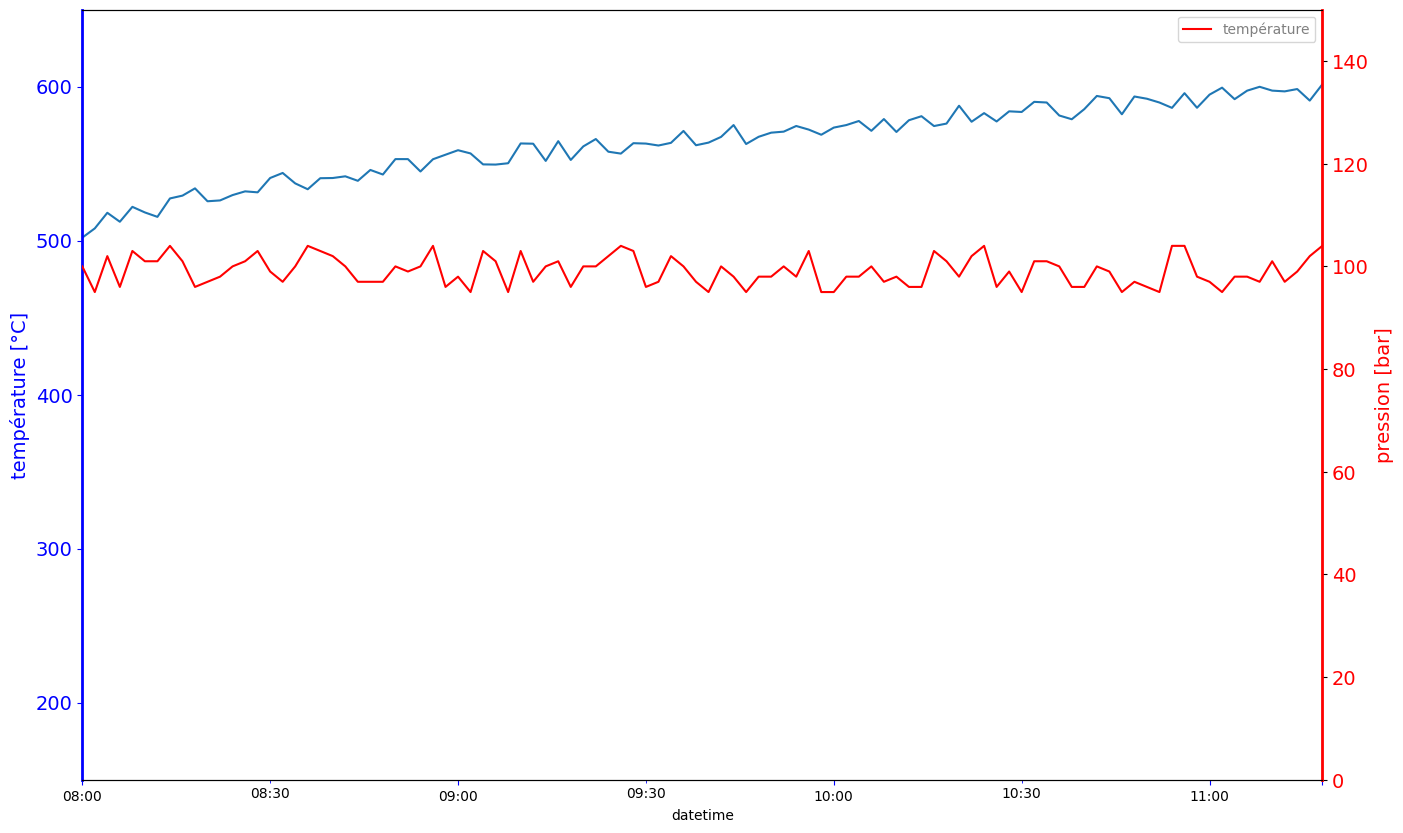

In [10]:
%matplotlib inline

ax = data["temperature [°C] , 000CT401"].plot(figsize=(16,10), legend=False)  # on récupère ax

ax.set_ylabel("température [°C]", color='blue', fontsize='14')
ax.set_ybound(150, 650)           # échelle des ordonnées
ax.spines.left.set_color('blue')
ax.spines.left.set_linewidth(2)
# ax.spines.right.set_visible(False) # cet axe va être superposé par l'axe en couleur qui est défini ensuite
ax.tick_params(color='blue', which='both')
ax.yaxis.label.set_color('blue')
for lbl in ax.get_yticklabels():
    lbl.set_color('blue')
    lbl.set_fontsize(14)


ax1 = data["pression [bar] , 000CP203"].plot(ax=ax.twinx(), color='red', legend=False)
ax1.set_ybound(0,150)
ax1.set_ylabel('pression [bar]', color='red', fontsize='14')

# contrôle visibilité et couleur des axes
ax1.spines.right.set_color('red')
ax1.spines.right.set_linewidth(2)
ax1.spines.left.set_visible(False) 

# couleur du titres des ordonnées de droite
ax1.yaxis.label.set_color('red')  

# couleur des étiquettes des ticks de droite
for lbl in ax1.get_yticklabels():
    lbl.set_color('red')
    lbl.set_fontsize(14)


plt.legend(labels=['température', 'pression'],loc='best', labelcolor='grey')
plt.show()


# Exercice sur les courbes de l'air humide

Cet exemple propose des courbes de l'air humide réalisé grâce à l'extension [CoolProp](http://www.coolprop.org/fluid_properties/HumidAir.html).



In [2]:
from CoolProp.HumidAirProp import HAPropsSI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Des fonctions de traductions entre les degrés Kelvin et Celsius.

In [3]:
def C2K(t):
    '''Celsius to Kelvin'''
    return t + 273.15

def K2C(t):
    '''Kelvin to Celsius'''
    return t - 273.15

In [4]:
# only one pressure used
p = 100200 # in Pascal

# Première méthode

Construction d'un fasceau de courbes.

In [48]:
# cette technique permet d'obtenir courbe rapidement: on connait les domaines et on se donne un nombre de points à y répartir
W_range = np.linspace(0.016, 0.022, 10, endpoint = True)
T_range = np.linspace(25, 40, 4, endpoint = True)

W_len = len(W_range)          # humidité absolue
W_ids = range(W_len)
T_len = len(T_range)          # température
T_ids = range(T_len)
R = np.zeros((W_len, T_len))  # initialisation de la matrice contenant les humidités relatives

# Construction de la matrice, certaines valeurs ne peuvent pas être calculées
# On utlise une technique qui intercept les erreurs prévisibles. C'est une technique rapide, mais qui peut poser des problèmes
# d'arrondis (voir la proposition suivante)
for w, w_id in zip(W_range, W_ids):
    for t, t_id in zip(T_range, T_ids):
        try:
            R[w_id, t_id] = round(100*HAPropsSI('R', 'T', C2K(t), 'P', p, 'W', w))
        except:
            R[w_id, t_id] = np.nan
R

array([[79., 59., 44., 34.],
       [82., 61., 46., 35.],
       [85., 64., 48., 37.],
       [89., 66., 50., 38.],
       [92., 68., 52., 39.],
       [95., 71., 53., 41.],
       [98., 73., 55., 42.],
       [nan, 76., 57., 43.],
       [nan, 78., 59., 45.],
       [nan, 80., 61., 46.]])

Construction des étiquettes.

In [9]:
T_labels = [f'{t:.0f}°C' for t in T_range]
T_labels

['25°C', '30°C', '35°C', '40°C']

In [13]:
W_labels = list(np.around(1000*W_range, 1))
W_labels

[16.0, 16.7, 17.3, 18.0, 18.7, 19.3, 20.0, 20.7, 21.3, 22.0]

/tmp/ipykernel_8218/1994596929.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(W_labels)


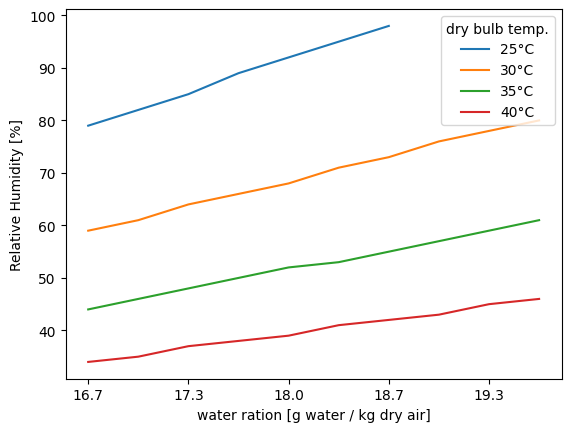

In [14]:
fig, ax = plt.subplots()

ax.plot(R)

ax.set_xlabel('water ration [g water / kg dry air]')
ax.set_ylabel('Relative Humidity [%]')

ax.set_xticklabels(W_labels)
ax.legend(T_labels, title="dry bulb temp.")
plt.show()

## Deuxième exemple


In [50]:
# ici on préfère définir l'écart entre les points que le nombres de points
T_range = np.arange(18, 48, 2)
T_range

array([18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46])

In [51]:
# On récupère les indices correspondants la liste précédente
T_len = len(T_range)
T_ids = range(T_len)

# vérification
for id in T_ids:
    print(T_range[id], end=' ')

18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 

In [52]:
# température de bulbe humide
Tw_range = np.arange(18, 40, 2)
Tw_range

array([18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38])

In [53]:
Tw_len = len(Tw_range)
Tw_ids = range(Tw_len)

for id in Tw_ids:
    print(Tw_range[id], end=' ')

18 20 22 24 26 28 30 32 34 36 38 

Préparation des étiquettes.

In [54]:
T_labels = [f'{t:.0f}°C' for t in T_range.round()]
print(T_labels)
Tw_labels = [f'{t:.0f}°C' for t in Tw_range.round()]
print(Tw_labels)

['18°C', '20°C', '22°C', '24°C', '26°C', '28°C', '30°C', '32°C', '34°C', '36°C', '38°C', '40°C', '42°C', '44°C', '46°C']
['18°C', '20°C', '22°C', '24°C', '26°C', '28°C', '30°C', '32°C', '34°C', '36°C', '38°C']


In [55]:
# initialisation de la matrice
R = np.zeros((T_len, Tw_len))
R.shape

(15, 11)

Remplissage de la matrice.

In [56]:
for t, t_id in zip(T_range, T_ids):
    for tw, tw_id in zip(Tw_range, Tw_ids):
        if tw > t:
            R[t_id, tw_id] = np.nan
        elif tw==t:
            R[t_id, tw_id] = 100
        else:
            R[t_id, tw_id] = round(100*HAPropsSI('R', 'T', C2K(t), 'P', p, 'Twb', C2K(tw)))        

In [58]:
# Le calcul de l'air humide pour le couple 18/Œ8 peut poser des problèmes d'arrondis.
HAPropsSI('R', 'T', C2K(18.1), 'P', p, 'Twb', C2K(18))

0.9906211172897377

In [57]:
from tabulate import tabulate
print(tabulate(R, showindex=T_labels, headers=Tw_labels, tablefmt='simple'))

        18°C    20°C    22°C    24°C    26°C    28°C    30°C    32°C    34°C    36°C    38°C
----  ------  ------  ------  ------  ------  ------  ------  ------  ------  ------  ------
18°C     100     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan
20°C      83     100     nan     nan     nan     nan     nan     nan     nan     nan     nan
22°C      68      84     100     nan     nan     nan     nan     nan     nan     nan     nan
24°C      56      70      84     100     nan     nan     nan     nan     nan     nan     nan
26°C      46      58      71      85     100     nan     nan     nan     nan     nan     nan
28°C      38      48      60      72      86     100     nan     nan     nan     nan     nan
30°C      30      40      50      61      73      86     100     nan     nan     nan     nan
32°C      24      33      42      52      63      74      87     100     nan     nan     nan
34°C      19      27      35      44      53      64      75      87  

Pour faciliter la génération de courbe, mais surtout les exports vers Excel, on traduit maintenant cette matrice en dataframe.

In [59]:
dw = pd.DataFrame(R)
dw

,0,1,2,3,4,5,6,7,8,9,10
0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68.0,84.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56.0,70.0,84.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,46.0,58.0,71.0,85.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
5,38.0,48.0,60.0,72.0,86.0,100.0,NaN,NaN,NaN,NaN,NaN
6,30.0,40.0,50.0,61.0,73.0,86.0,100.0,NaN,NaN,NaN,NaN
7,24.0,33.0,42.0,52.0,63.0,74.0,87.0,100.0,NaN,NaN,NaN
8,19.0,27.0,35.0,44.0,53.0,64.0,75.0,87.0,100.0,NaN,NaN
9,15.0,22.0,29.0,37.0,46.0,55.0,65.0,76.0,87.0,100.0,NaN


On va maintenant changer les titres de colonnes

In [60]:
dw1 = dw.rename(mapper = lambda x: Tw_labels[x], axis=1, inplace=False)
dw1

,18°C,20°C,22°C,24°C,26°C,28°C,30°C,32°C,34°C,36°C,38°C
0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68.0,84.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56.0,70.0,84.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,46.0,58.0,71.0,85.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
5,38.0,48.0,60.0,72.0,86.0,100.0,NaN,NaN,NaN,NaN,NaN
6,30.0,40.0,50.0,61.0,73.0,86.0,100.0,NaN,NaN,NaN,NaN
7,24.0,33.0,42.0,52.0,63.0,74.0,87.0,100.0,NaN,NaN,NaN
8,19.0,27.0,35.0,44.0,53.0,64.0,75.0,87.0,100.0,NaN,NaN
9,15.0,22.0,29.0,37.0,46.0,55.0,65.0,76.0,87.0,100.0,NaN


Changement des index.

In [61]:
Tx_labels = [x[0:2] for x in T_labels]  # on enlève le symbole '°C' pour gagner de la place
dw= dw1.rename(mapper = lambda x: Tx_labels[x], axis=0, inplace=False)
dw

,18°C,20°C,22°C,24°C,26°C,28°C,30°C,32°C,34°C,36°C,38°C
18,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,83.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,68.0,84.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,56.0,70.0,84.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,46.0,58.0,71.0,85.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
28,38.0,48.0,60.0,72.0,86.0,100.0,NaN,NaN,NaN,NaN,NaN
30,30.0,40.0,50.0,61.0,73.0,86.0,100.0,NaN,NaN,NaN,NaN
32,24.0,33.0,42.0,52.0,63.0,74.0,87.0,100.0,NaN,NaN,NaN
34,19.0,27.0,35.0,44.0,53.0,64.0,75.0,87.0,100.0,NaN,NaN
36,15.0,22.0,29.0,37.0,46.0,55.0,65.0,76.0,87.0,100.0,NaN


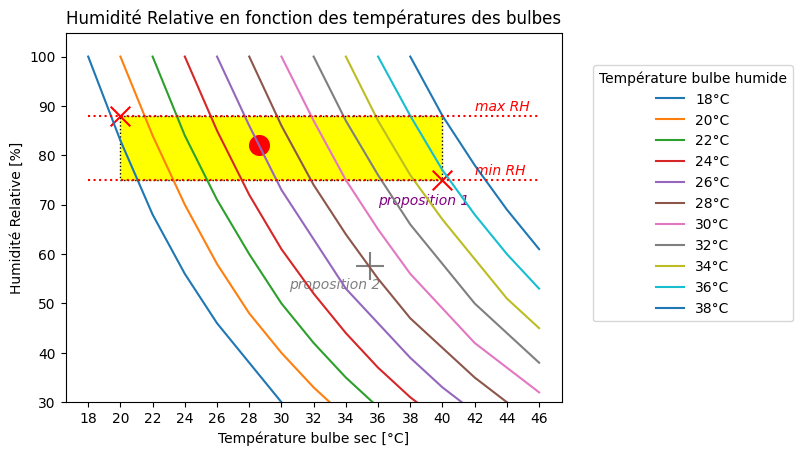

In [62]:
# dw.plot()   # short version, but need to use gca() to add titles
fig, ax = plt.subplots()
ax.plot(dw)
x_range = dw.index.to_list()

ax.plot(x_range, [75]*len(x_range), color='red', linestyle='dotted')  # limite basse de 'Humidité Relative
ax.annotate('min RH', xy=(x_range[-3],75), xytext=(x_range[-3],76), style='italic', color='red')
ax.plot(x_range, [88]*len(x_range), color='red', linestyle='dotted')   # limite haute
ax.annotate('max RH', xy=(x_range[-3], 88), xytext=(x_range[-3], 89), style='italic', color='red')

Tlow, Tref, Thigh = ((20-18)/2, (28.6-18)/2, (40-18)/2)
ax.scatter([Tlow], [88], marker='x', s=200, color='red')
ax.scatter([Tref], [82], marker='o', s=200, color='red')
ax.scatter([Thigh], [75], marker='x', s=200, color='red')
ax.annotate('proposition 1', xy=(Thigh,75), xytext=(Thigh-2,70), style='italic', color='purple', zorder=1)

Thigh1 = (35.5-18)/2
ax.scatter([Thigh1], [57.6], marker='+', s=400, c='gray')
ax.annotate('proposition 2', xy=(Thigh,57.6), xytext=(Thigh1-2.5,53), style='italic', color='gray', zorder=1)

# marquer une zone avec un patch
from matplotlib.path import Path
import matplotlib.patches as patches
vertices = [(Tlow, 88), (Thigh,88), (Thigh,75), (Tlow,75), (Tlow,88)]
codes=[Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
path=Path(vertices, codes)
patch = patches.PathPatch(path, facecolor='yellow', lw=1, ls='dotted', zorder=0)
ax.add_patch(patch)
# -------------------

plt.ylim(30)
ax.set_xlabel('Température bulbe sec [°C]')
ax.set_ylabel('Humidité Relative [%]')
ax.legend(Tw_labels, title="Température bulbe humide", loc='lower left', bbox_to_anchor=(1.05,0.2))
ax.set_title('Humidité Relative en fonction des températures des bulbes')
plt.savefig("humide.svg", format='svg')
plt.show()

In [39]:
dw.to_excel('humide.xlsx')